# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule).

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [4]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

try:
  import google.colab
  IN_COLAB = True
  print('You are using Google Colab')
  !pip install googledrivedownloader
  from googledrivedownloader import download_file_from_google_drive
except:
  IN_COLAB = False

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.random.seed(seed=42)
from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data

In [5]:
## Read data
Working_directory="data/"
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

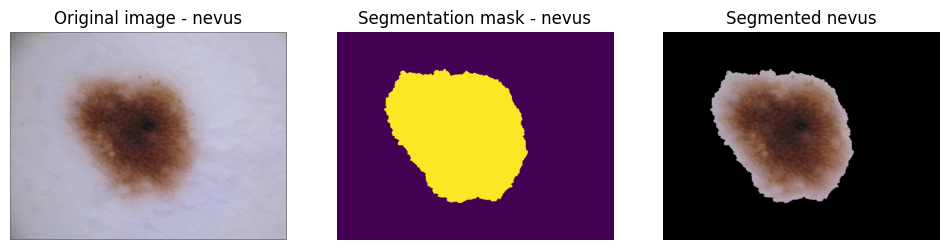

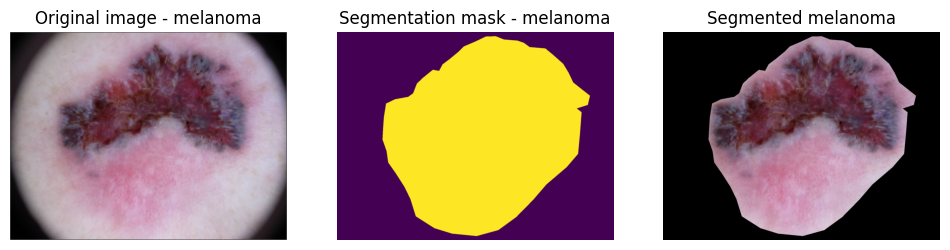

In [6]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg')
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg')
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [7]:
# Shuffle data randomly
idx = np.arange(N)
np.random.shuffle(idx)
Xp=X[idx]
yp=y[idx]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

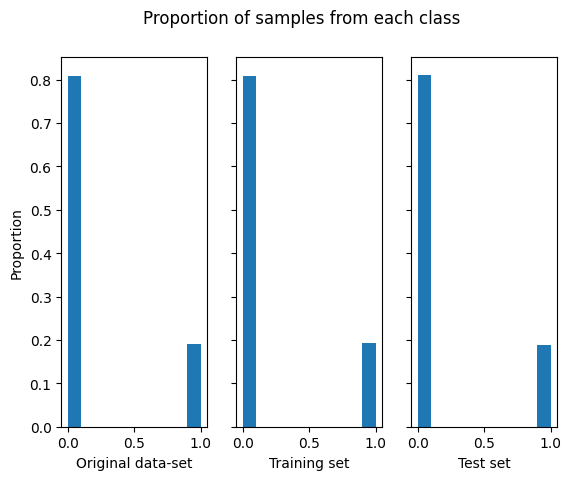

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Réponse**

Il faut déterminer les paramètres du scaling uniquement sur les données d'entrainement et ensuite utiliser ces mêmes paramètres pour scale les données de test. De cette manière, on évite le data leakage car on n'est pas censés avoir accès aux données de test pendant l'entrainement.

In [9]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices.

**Question**: Comment the results.

**Réponse**

Les 2 méthodes ont des bons résultats sur la classe healthy mais sont mauvaise sur la classe melanoma car le dataset n'est pas équilibré entre les 2 classes. Cependant LDA est légèrement plus performant que QDA sur les 2 classes.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       146
           1       0.62      0.29      0.40        34

    accuracy                           0.83       180
   macro avg       0.74      0.63      0.65       180
weighted avg       0.81      0.83      0.81       180

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.70588235 0.29411765]]


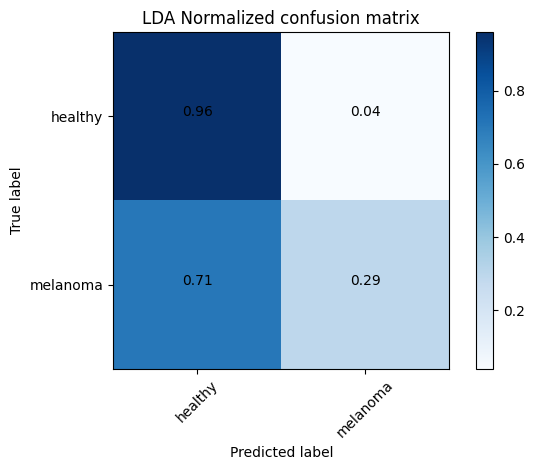

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.53      0.24      0.33        34

    accuracy                           0.82       180
   macro avg       0.69      0.59      0.61       180
weighted avg       0.78      0.82      0.79       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.76470588 0.23529412]]


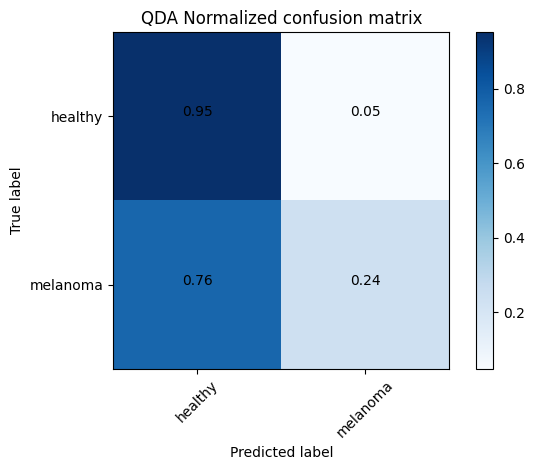

In [10]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred_qda = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred_qda))

# Compute confusion matrix
cnf_matrix_qda = confusion_matrix(y_test, y_pred_qda)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_qda, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Réponse**

Pour réduire le biais de la subdivision arbitraire des données on peut utiliser la cross validation.

In [11]:
# Fitting LDA
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=Xp, y=yp,cv=3)
print(np.mean(lda_score))

# Fitting QDA
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=Xp, y=yp,cv=3)
print(np.mean(qda_score))

# Fitting K-nearest neighbour
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
neigh_score = cross_val_score(neigh,X=Xp, y=yp,cv=3)
print(np.mean(neigh_score))

0.8116666666666666
0.8083333333333332
0.8133333333333334


---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation.

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

**Réponse**

On voit également une très mauvaise classification sur la classe melanoma car le dataset est mal équilibré entre les 2 classes et KNN a tendance à mal classifier la classe de plus faible cardinal car les voisins les plus proches sont souvent ceux de la classe majoritaire.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8261904761904763
Best training params: {'kneighborsclassifier__n_neighbors': 7}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


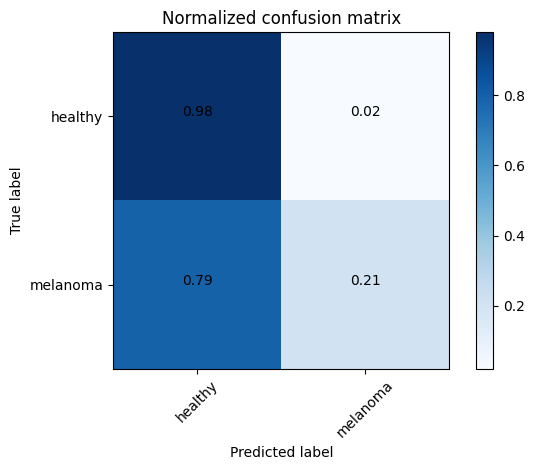

In [12]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions.

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Réponse**

On voit que la fonction de score "recall" a de moins bonnes performances sur la classe healthy mais de meilleures performances sur la classe melanoma donc un résultat plus équilibré (que la fonction accuracy)

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8261904761904763
Best training params: {'kneighborsclassifier__n_neighbors': 7}
accuracy
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


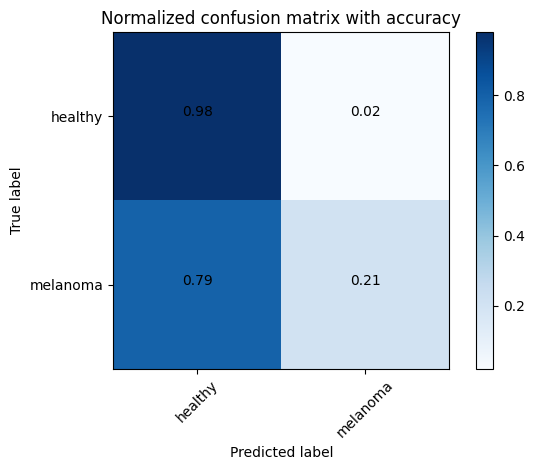

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.32132352941176473
Best training params: {'kneighborsclassifier__n_neighbors': 1}
recall
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.61764706 0.38235294]]


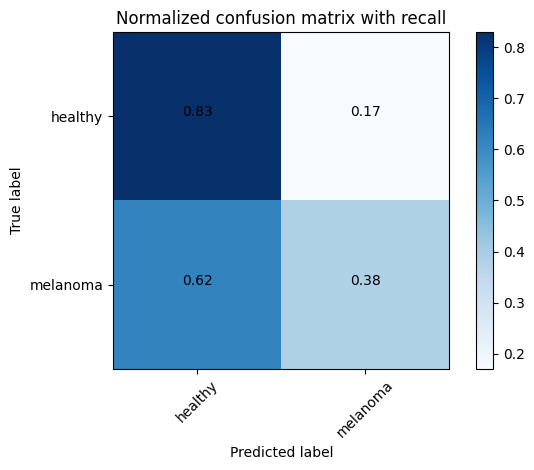

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.12781105645884705
Best training params: {'kneighborsclassifier__n_neighbors': 5}
v_measure_score
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


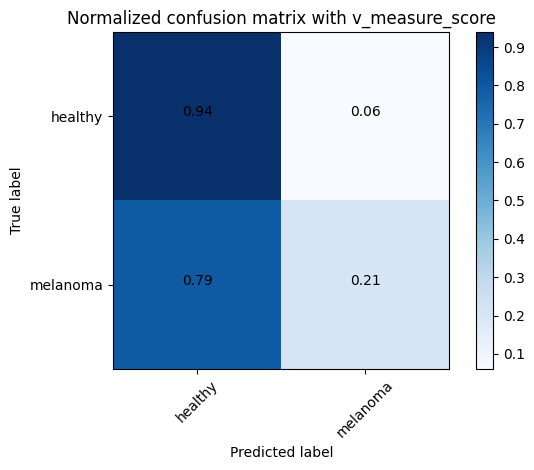

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.34113181504485846
Best training params: {'kneighborsclassifier__n_neighbors': 5}
f1
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


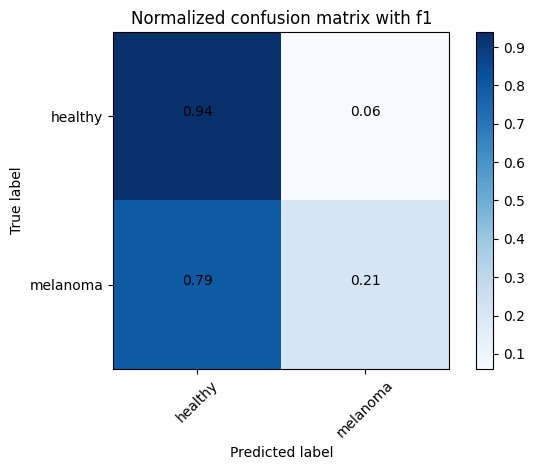

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.75
Best training params: {'kneighborsclassifier__n_neighbors': 4}
precision
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.85294118 0.14705882]]


/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


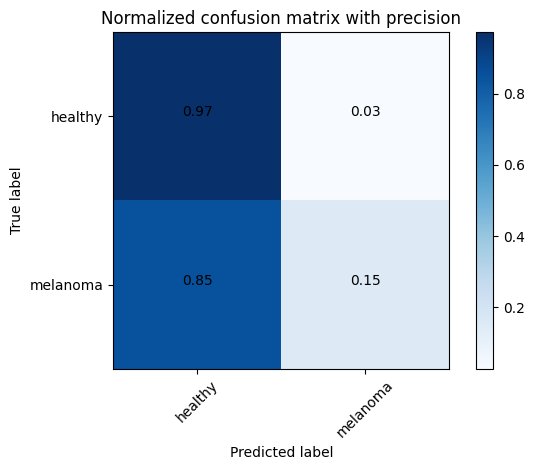

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.6856727392449519
Best training params: {'kneighborsclassifier__n_neighbors': 10}
roc_auc
Normalized confusion matrix
[[0.99315068 0.00684932]
 [0.88235294 0.11764706]]


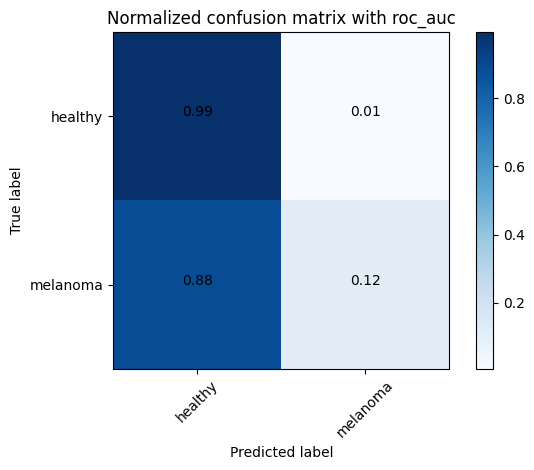

In [13]:
# Looking for the best hyperparameters
scoring_functions = ['accuracy','recall','v_measure_score','f1','precision','roc_auc']# Looking for the best hyperparameters
for metric in scoring_functions:
    neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
    # when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
    print(neigh.get_params().keys())
    p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=metric, cv=5)
    grid_KNN.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    y_pred = grid_KNN.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix
    print(metric)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title=f'Normalized confusion matrix with {metric}')
    plt.show()

On remarque que les courbes sur les données sous-échantillonées ont des variations plus abruptes dans leur courbure et légèrement en escalier par rapport aux courbes normales. D'autre par la précision sur les données sous-échantillonées est supérieur d'environs 0.02 à celle normale entre 0 et 0.6 de rappel.

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage.

In [14]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 328)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set.

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Réponse**

Oui les résultats sont meilleurs, bien que moins précis sur la classe healthy, ils sont meilleurs sur la classe melanoma et donc on a un meilleur équilibre entre les classes. Oui les résultats sont modifiés en fonction de la fonction de score, le K optimal est changé entre 1,2,4 et les meilleurs résultats sont avec roc_auc avec K=4. Maintenant que le dataset est plus balancé on voit plus de différences avec les métriques car elles sont moins soumises au biais du dataset mal équilibré.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8485467399842891
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.52941176 0.47058824]]


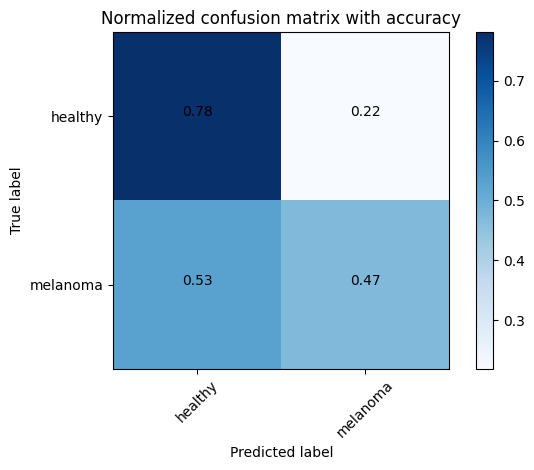

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 1.0
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.68493151 0.31506849]
 [0.41176471 0.58823529]]


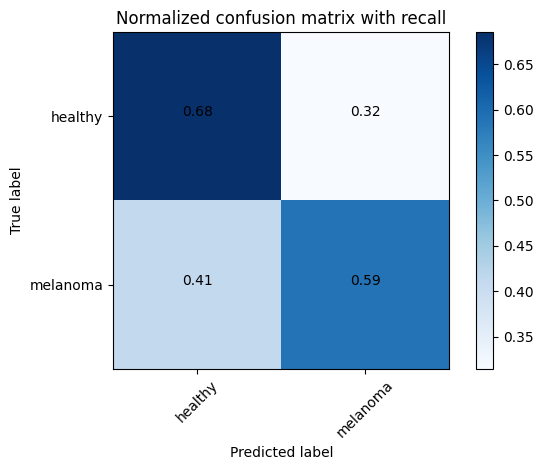

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.48730618444653623
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.68493151 0.31506849]
 [0.41176471 0.58823529]]


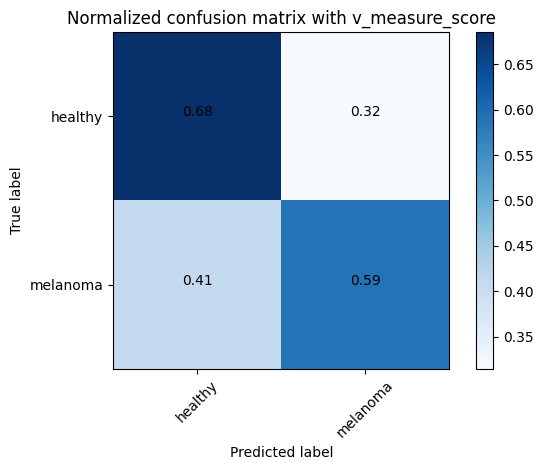

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8595900482258632
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.52941176 0.47058824]]


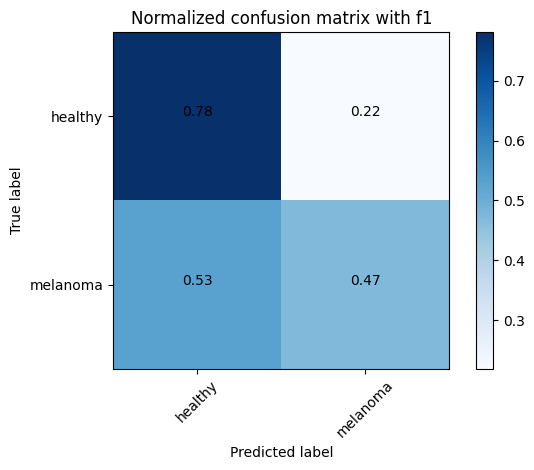

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.7901683009611398
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.52941176 0.47058824]]


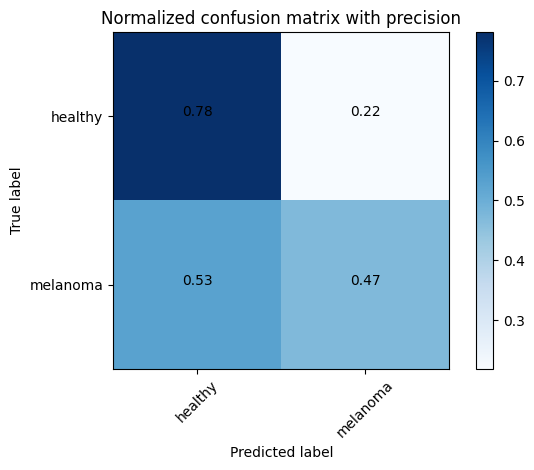

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8963678419911958
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.69178082 0.30821918]
 [0.32352941 0.67647059]]


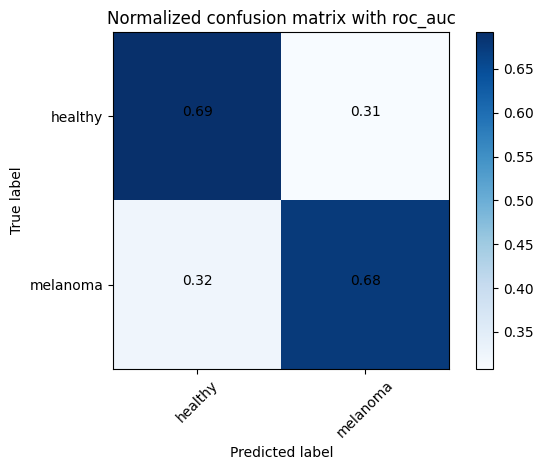

In [15]:
# Looking for the best hyperparameters
for metric in scoring_functions:
    neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
    # when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
    print(neigh.get_params().keys())
    p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=metric, cv=5)
    grid_KNN.fit(X_resampled, y_resampled)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    y_pred = grid_KNN.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title=f'Normalized confusion matrix with {metric}')
    plt.show()

Let's use the techniques seen today: Perceptron and linear SVM.

In [16]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7920833333333334 +- 0.032446537223219635
 Average and std TEST CV accuracy : 0.7733333333333333 +- 0.03704351795148813
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8408333333333333 +- 0.007168604389202164
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.01748014746950254


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [17]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7920833333333334 +- 0.032446537223219635
 Average and std TEST CV accuracy : 0.7733333333333333 +- 0.03704351795148813
 Average and std TRAIN CV f1 : 0.3258083954708111 +- 0.08835977702696353
 Average and std TEST CV f1 : 0.2751282863477985 +- 0.11406450966266812
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8408333333333333 +- 0.007168604389202164
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.01748014746950254
 Average and std TRAIN CV f1 : 0.4110762305644453 +- 0.04162081984474546
 Average and std TEST CV f1 : 0.3312736386420597 +- 0.0901562888956756


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


**Réponse**

On peut voir que le suréchantillonage des données à améliorés les résultats avec la fonction de score f1 pour Perceptron et LSVM mais à diminué leurs résultats avec la fonction de score accuracy.

In [18]:
from imblearn.pipeline import make_pipeline as make_pipeline2

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.67 +- 0.018474832731162787
 Average and std TEST CV accuracy : 0.6383333333333333 +- 0.03055050463303895
 Average and std TRAIN CV f1 : 0.4313567828314711 +- 0.02691261841655205
 Average and std TEST CV f1 : 0.37069292006217913 +- 0.05294889849396223
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.76 +- 0.009446486707295542
 Average and std TEST CV accuracy : 0.7133333333333335 +- 0.02915475947422648
 Average and std TRAIN CV f1 : 0.5247722066073649 +- 0.017513628049843487
 Average and std TEST CV f1 : 0.4321708379508217 +- 0.059309421059271145


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data.
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data.

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6464285714285716 +- 0.037144001813863556
 Average and std TEST CV accuracy : 0.6023809523809525 +- 0.057636754461477153
 Average and std TRAIN CV f1 : 0.41301998227446857 +- 0.027224457863164485
 Average and std TEST CV f1 : 0.3706457532832483 +- 0.07335597917477432
Normalized confusion matrix
[[0.62328767 0.37671233]
 [0.29411765 0.70588235]]


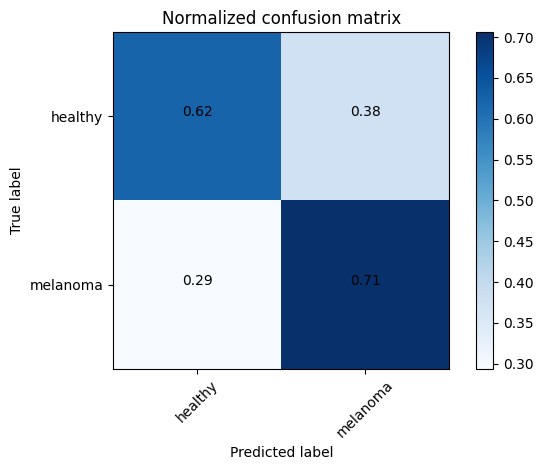

Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7702380952380953 +- 0.020395049641680738
 Average and std TEST CV accuracy : 0.7214285714285714 +- 0.01428571428571428
 Average and std TRAIN CV f1 : 0.5344141889501601 +- 0.03273398931010411
 Average and std TEST CV f1 : 0.42266971777269263 +- 0.07317736716329173
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.5        0.5       ]]


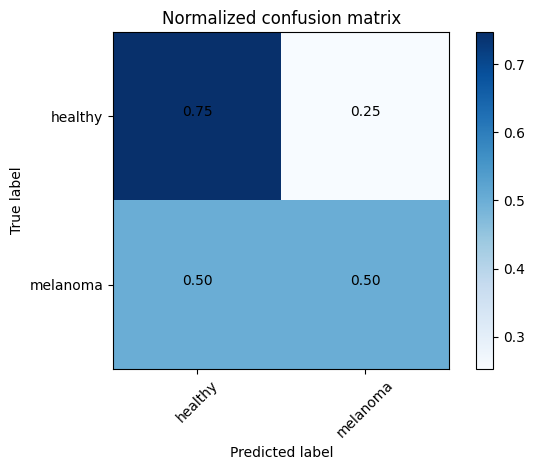

In [19]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model.

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7428571428571429
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.41176471 0.58823529]]


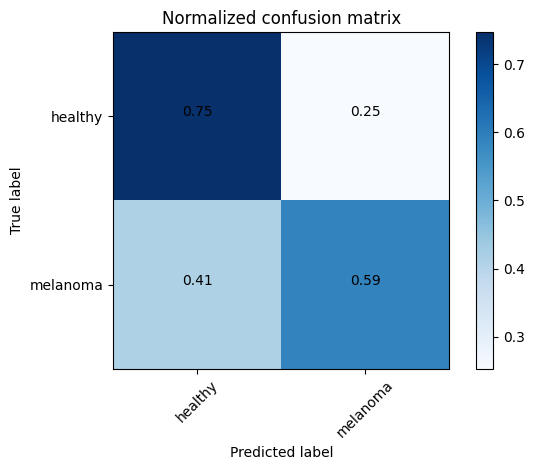

In [20]:
# Looking for the best hyperparameter C
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)

grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.4705612812099961
Best training params: {'svc__C': 2, 'svc__gamma': 0.001}
Normalized confusion matrix
[[0.79452055 0.20547945]
 [0.38235294 0.61764706]]


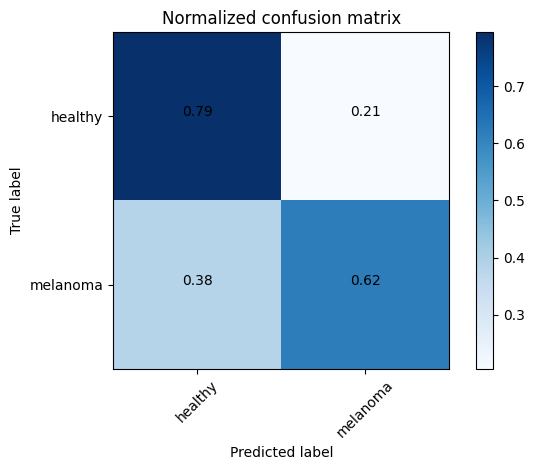

In [21]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Réponse**

On peut voir que le sur-échantillonage améliore globalement les résultats sur toutes les métriques en donnant une précision plus équilibrée sur les 2 classes, on augmente donc la précision sur la classe melanoma mais on réduit celle sur la classe healthy. En effet les données de base étant très déséquilibrées entre les 2 classes, on a tendance à beaucoup plus prédire la classe healthy ce qui entraine une très bonne précision sur cette dernière mais une mauvaise sur la classe melanoma qui est minoritaire.

Les fonctions de score influent également beaucoup sur les résultats : précision et accuracy maintiennent de très bons résulats sur la classe healthy et améliorent ceux sur melanoma (mais restent assez faible sur cette dernière) tandis que recall, f1 et roc_auc diminuent les résultats sur healthy et augmentent grandement ceux sur melanoma donnant un résultat équilibré mais globalement peu précis.

Best training Score on original data (accuracy): 0.8261904761904763
Best training params on original data (accuracy): {'svc__C': 4, 'svc__gamma': 0.005}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.88235294 0.11764706]]


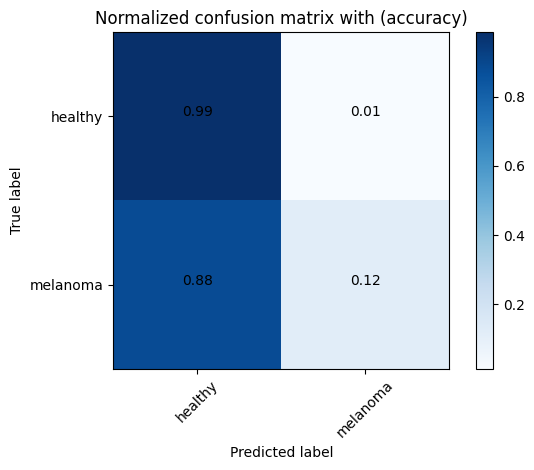

Best training Score on oversampled data (accuracy): 0.8238095238095239
Best training params on oversampled data (accuracy): {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


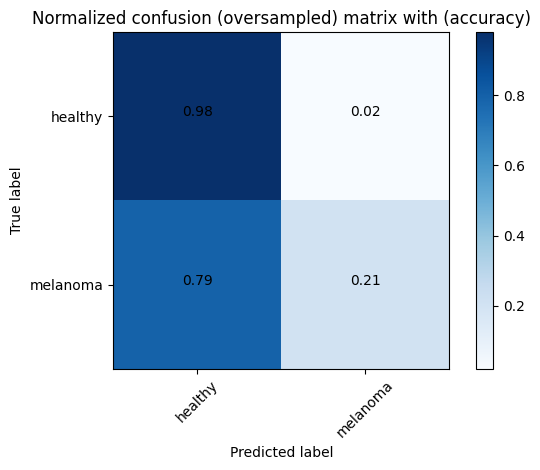

Best training Score on original data (recall): 0.23602941176470588
Best training params on original data (recall): {'svc__C': 10.0, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.82352941 0.17647059]]


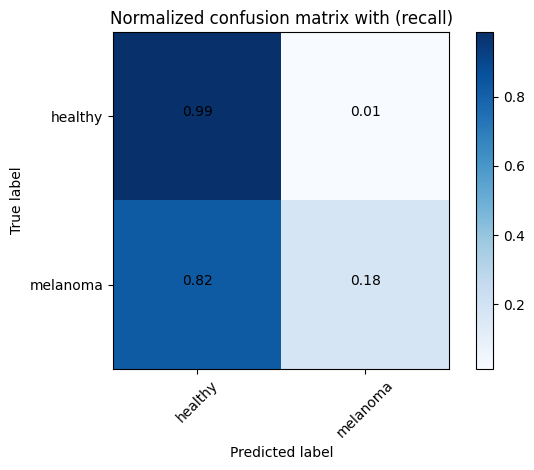

Best training Score on oversampled data (recall): 0.5698529411764706
Best training params on oversampled data (recall): {'svc__C': 7, 'svc__gamma': 0.001}
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.35294118 0.64705882]]


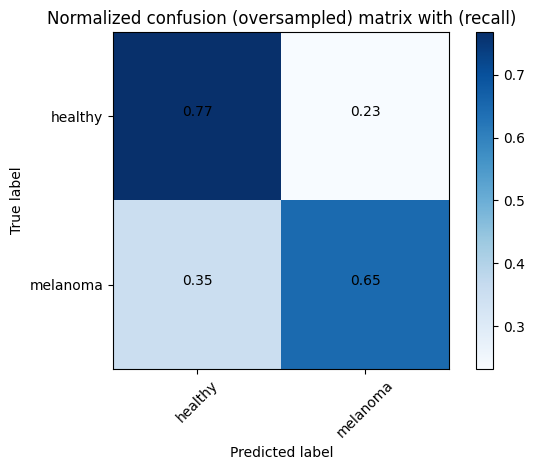

Best training Score on original data (v_measure_score): 0.11259565063052893
Best training params on original data (v_measure_score): {'svc__C': 4, 'svc__gamma': 0.005}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.88235294 0.11764706]]


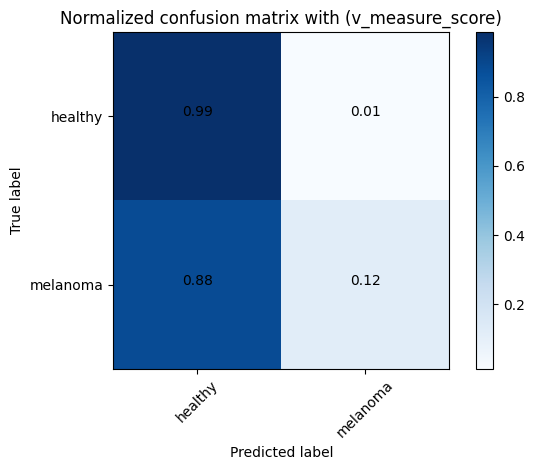

Best training Score on oversampled data (v_measure_score): 0.11608740934879784
Best training params on oversampled data (v_measure_score): {'svc__C': 7, 'svc__gamma': 0.0001}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.5        0.5       ]]


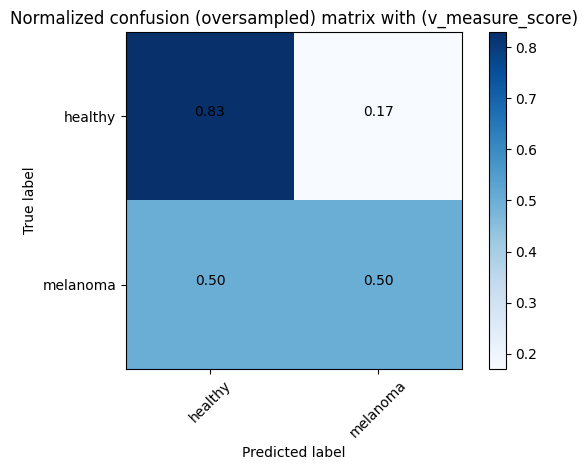

Best training Score on original data (f1): 0.3195944406470722
Best training params on original data (f1): {'svc__C': 10.0, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.82352941 0.17647059]]


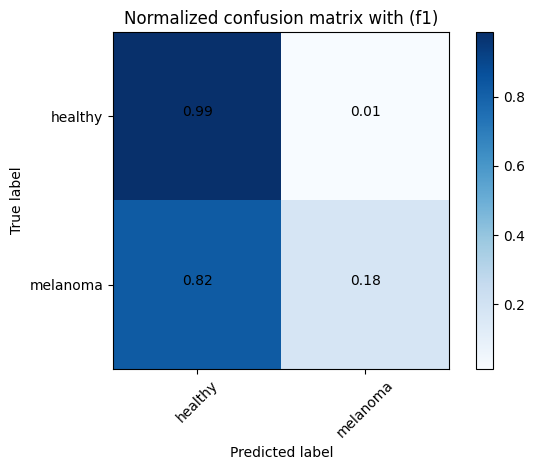

Best training Score on oversampled data (f1): 0.4705612812099961
Best training params on oversampled data (f1): {'svc__C': 2, 'svc__gamma': 0.001}
Normalized confusion matrix
[[0.79452055 0.20547945]
 [0.38235294 0.61764706]]


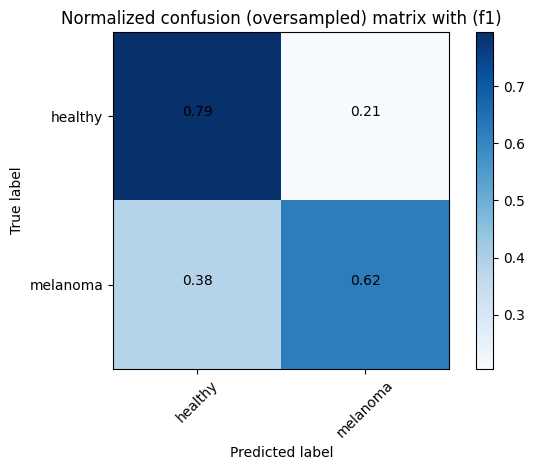

/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/s

Best training Score on original data (precision): 0.8
Best training params on original data (precision): {'svc__C': 3, 'svc__gamma': 0.005}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.94117647 0.05882353]]


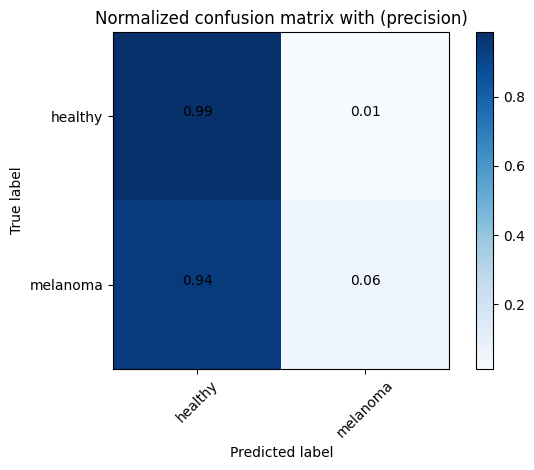

/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/s

Best training Score on oversampled data (precision): 0.7
Best training params on oversampled data (precision): {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.79411765 0.20588235]]


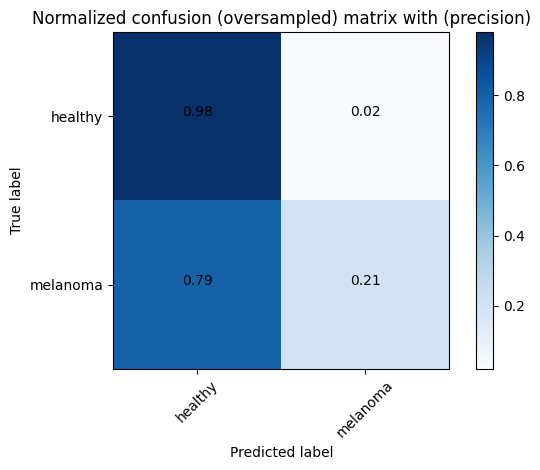

Best training Score on original data (roc_auc): 0.7488449297629499
Best training params on original data (roc_auc): {'svc__C': 0.01, 'svc__gamma': 0.0005}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


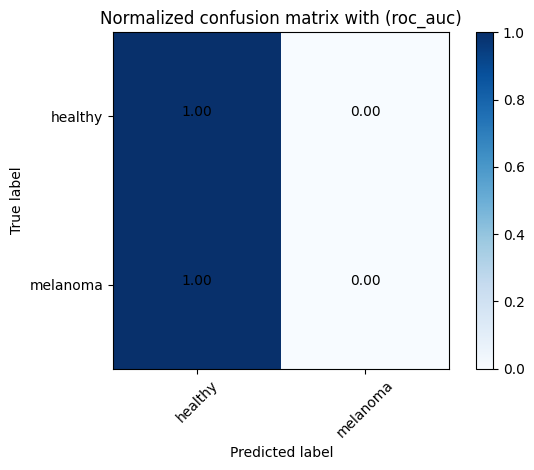

Best training Score on oversampled data (roc_auc): 0.7696169885864794
Best training params on oversampled data (roc_auc): {'svc__C': 3, 'svc__gamma': 0.001}
Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.35294118 0.64705882]]


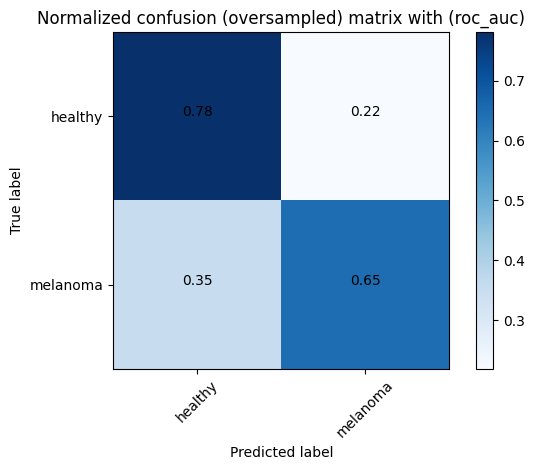

In [22]:
for metric in scoring_functions:
    NLsvm = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
    p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring=metric, cv=5)
    grid_nlsvm.fit(X_train, y_train)
    print(f"Best training Score on original data ({metric}): {grid_nlsvm.best_score_}")
    print(f"Best training params on original data ({metric}): {grid_nlsvm.best_params_}")
    y_pred = grid_nlsvm.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title=f'Normalized confusion matrix with ({metric})')
    plt.show()
    
    
    NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf'))
    p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring=metric, cv=5)
    grid_nlsvm.fit(X_train, y_train)
    print(f"Best training Score on oversampled data ({metric}): {grid_nlsvm.best_score_}")
    print(f"Best training params on oversampled data ({metric}): {grid_nlsvm.best_params_}")
    y_pred = grid_nlsvm.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title=f'Normalized confusion (oversampled) matrix with ({metric})')
    plt.show()

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Réponse**

Avec les résultats précédents, on peut conclure que les meilleurs résultats obtenus pour ce dataset sont avec la méthode Non-linear SVM, les fonctions de score recall et f1 qui donnent des résultats très semblables avec le meilleur équilibre de précision sur les 2 classes et le dataset sur-échantilloné pour réduire le biais de déséquilibre entre les 2 classes.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

**Réponse**

On peut voir que l'utilisation de PCA n'a pas le même impact suivant la fonction de score. Il améliore les résultats pour accuracy et precision qui étaient très déséquilibrées entre les 2 classes en diminuant grandement la précision sur healthy mais augmentant grandement celle sur melanoma. Pour f1 et v_measure on remarque les mêmes changements mais dans une plus faible mesure donc PCA a peu d'impact ici. Cependant pour les fonctions de score qui avaient déjà des résultats équilibrés précédemment (recall et roc_aux) l'utilisation de PCA dégrade les résultats sur les 2 classes.

Best training Score: 0.7428571428571429
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.73972603 0.26027397]
 [0.47058824 0.52941176]]


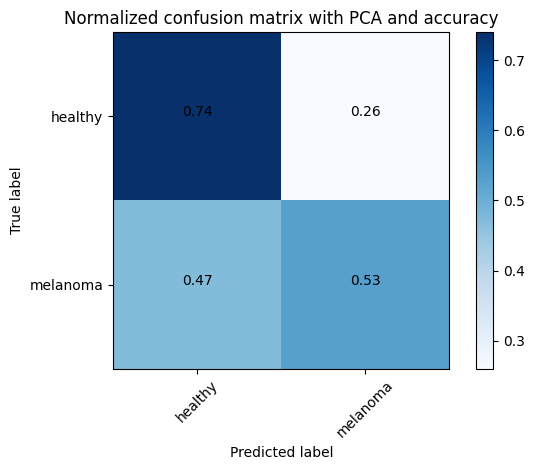

Best training Score: 0.6073529411764705
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.41176471 0.58823529]]


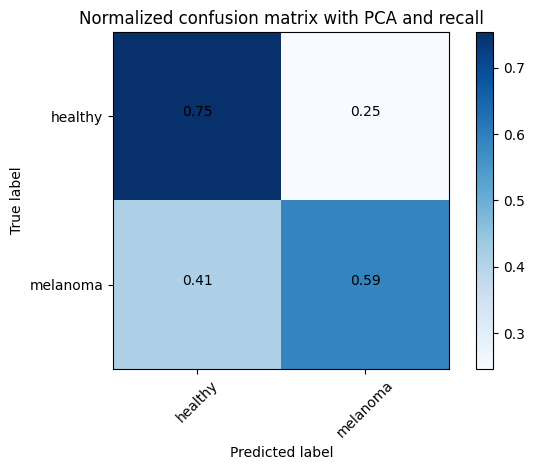

Best training Score: 0.0905279128133585
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.41176471 0.58823529]]


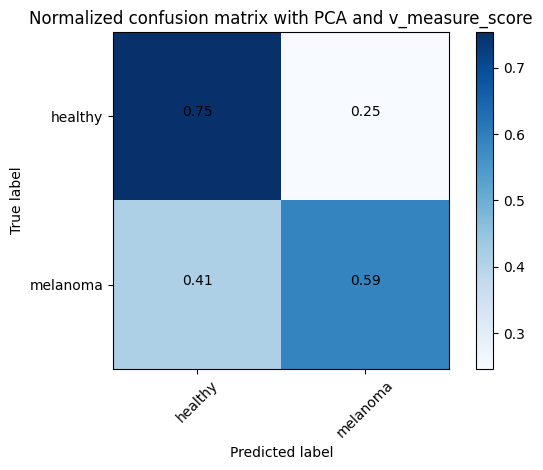

Best training Score: 0.45681748556616003
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.41176471 0.58823529]]


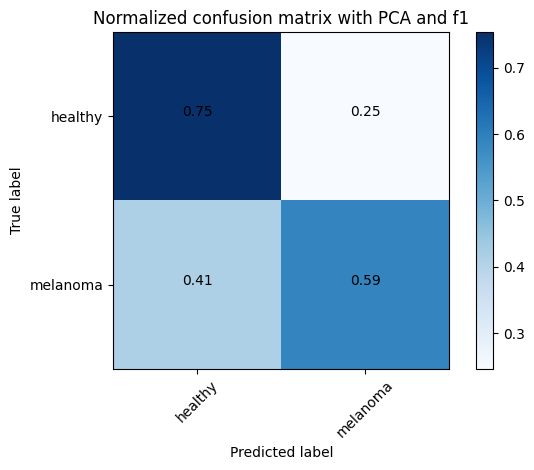

Best training Score: 0.37809853190287973
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.73972603 0.26027397]
 [0.47058824 0.52941176]]


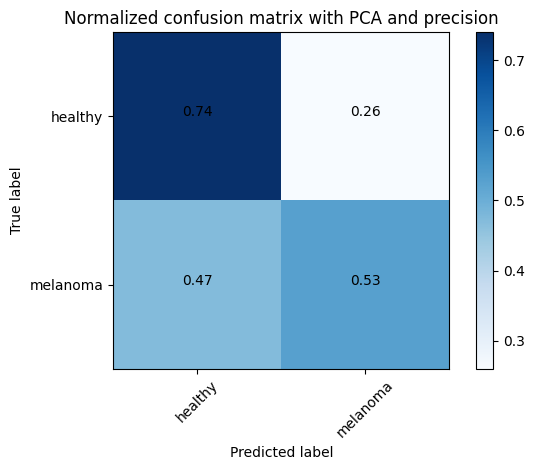

Best training Score: 0.7525954784899034
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.41176471 0.58823529]]


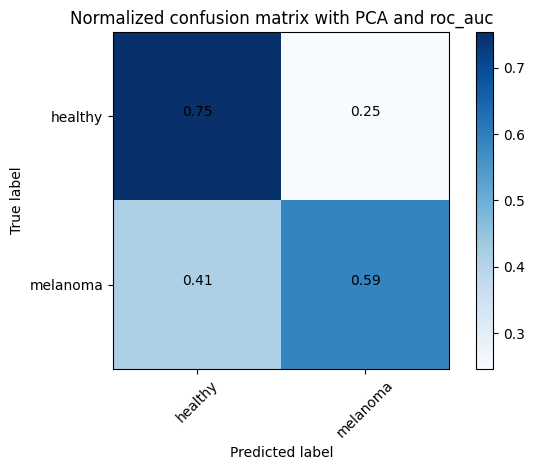

In [23]:
# Test PCA with a linear SVM
for metric in scoring_functions:
    Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC())
    p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

    grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring=metric, cv=5)

    grid_lsvm.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_lsvm.best_score_))
    print("Best training params: {}".format(grid_lsvm.best_params_))
    y_pred = grid_lsvm.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title=f'Normalized confusion matrix with PCA and {metric}')
    plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas.

**Réponse**

On peut voir ici qu'avec seulement 4 features on obtient un résultat très concluant avec même une augmentation de la précision par rapport au Non-linear SVM avec la fonction de score f1 sur le dataset sur-échantilloné.

Best features : [29, 15, 16, 3]
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.32352941 0.67647059]]


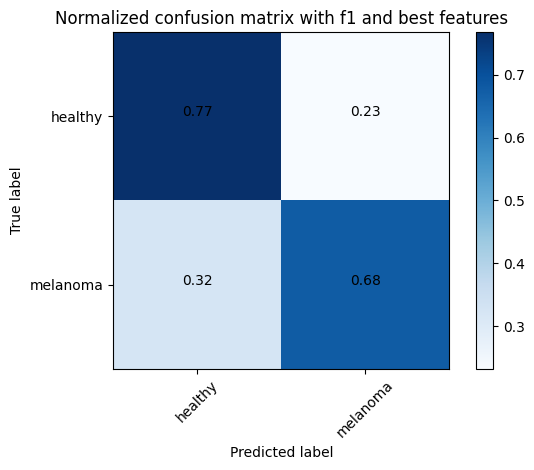

In [24]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM
from sklearn.metrics import f1_score

NLsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

def evaluate_model(X_train, y_train, X_test, y_test, features):
    X_train_selected_features = X_train[:, features]
    X_test_selected_features = X_test[:, features]
    
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)
    grid_nlsvm.fit(X_train_selected_features, y_train)
    y_pred = grid_nlsvm.predict(X_test_selected_features)
    return f1_score(y_test, y_pred)


selected_features = []
remaining_features = list(range(X_train.shape[1]))
best_f1 = 0

while remaining_features:
    best_feature = None
    for feature in remaining_features:
        current_features = selected_features + [feature]
        f1 = evaluate_model(X_train, y_train, X_test, y_test, current_features)
        if f1 > best_f1:
            best_f1 = f1
            best_feature = feature
    
    if best_feature is not None:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    else:
        break

print("Best features :", selected_features)

X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]
grid_nlsvm.fit(X_train_selected, y_train)
y_pred = grid_nlsvm.predict(X_test_selected)

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                    title=f'Normalized confusion matrix with f1 and best features')
plt.show()